In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
input_path = '/Volumes/Behaviour/S1 2P Recordings for Suite2P'
output_path = '/Volumes/Behaviour/S1 2P Neural Tuning/99th Percentile Long'


In [4]:
directories = [x[0] for x in os.walk(input_path) if os.path.basename(x[0]) == 'plane0']
thresholds99 = pd.DataFrame()

for directory in directories:
    print('Processing:', directory)
    stop = False
    meta = directory.split('/')  #directory.split('\\') 
    session_name = meta[4] #meta[3] 
    print(session_name)
    
    # load Suite2P outputs
    F = np.load(os.path.join(directory, 'F.npy'))
    Fneu = np.load(os.path.join(directory, 'Fneu.npy'))
    iscell = np.load(os.path.join(directory,'iscell.npy'), allow_pickle=True)
                             
    # read trial timings
    sf_path = meta[0]+'/'+meta[1]+'/'+meta[2]+'/'+meta[3] +'/'+ meta[4]
    sf_qc = pd.read_csv(os.path.join(sf_path, '2P_SF_QC.csv'))
    stimframes = np.array(sf_qc['2p_realstim_frame'])
    idx = list(sf_qc['identifier'])
    
    # Subtract neuropil signal from raw traces
    Fc = F - 0.7 * Fneu
    print('matrix shape: ', F.shape)
    
    # Get list of ROIS that are not cells
    iscell = pd.DataFrame(iscell)
    iscell_idx = iscell[0] == 1
    
    # Remove non-cell ROIs from raw traces & raw traces without neuropil
    df_F = pd.DataFrame(F)
    F_isCell = df_F.loc[iscell_idx]
    
    df_Fc = pd.DataFrame(Fc)
    Fc_isCell = df_Fc.loc[iscell_idx]
                             
    # remove ROIs with zero values from raw traces and get new list of indecis corresponding to active ROIs
    F_nonZero = F_isCell.loc[~(F_isCell==0).all(axis=1)]
    activeROIs = list(F_nonZero.index.values)
    print('number of active rois: ', len(activeROIs))

    # keep only active ROIs in F-neuropil
    Fc_Act = df_Fc.loc[df_Fc.index[activeROIs]]
    print('active rois matrix shape: ', Fc_Act.shape)
                             
    if stimframes[0]-183 <0: # determine appropriate length of pre-stimulus baseline based on the number 
        TBL_len = int(stimframes[0]-1) # of frames available before the very first stimulation
    else:
        TBL_len = 183 # default baseline is 30 s (30 * 6.1 fps = 183)
        
# for each active ROI, calculate 5th percentile, then cut out 30 sec pre-, and 60 sec post-stimulation 
# traces and use these to calculate F0 (I call it T0 since it is trial based) as the mean of Q5 in the trial window.
# Then, compute trial-wise dF_F0 (I called them dT_T0) an crop those to a 3 second window centered sround stimulation.
    
    neural_tuning = pd.DataFrame()
    tuned_maxis = pd.DataFrame()
    thresholds = []
    # Generate random distribution of 1999 time points within the recording session and use those to create random 
    # trial windows, then take baseline-subtracted maximum for each of them. Response thresholds = 99th percentile 
    # of the random distribution.
    rand_s = random.sample(range(TBL_len, Fc_Act.shape[1]-366), 1999)
    for r, roi in enumerate(activeROIs):
        Fc_Q05 = Fc_Act.iloc[r,:].rolling(366, center = True).quantile(0.05) # 5th percentile of neuropil-corrected F trace
        
        rand_dist = []
        for rs in rand_s:
            start = int(rs) - int(TBL_len)
            end = int(rs) + 366 # 60 sec * 6.1 fps
            T = Fc_Act.iloc[r,start:end] # trial window of neuropil-corrected F trace
            T_Q05 = Fc_Q05.iloc[start:end] # trial window of 5th percentile trace
            T0 = T_Q05.mean()
            dT_T0_long = (T - T0)/T0
            #tailored_long = pd.concat([tailored_long, dT_T0_long], axis=0)
            #start_short = int(rs) - 9 
            #end_short = int(rs) + 9
            baseline = dT_T0_long.loc[(int(rs)-3):(int(rs)-1)].mean()
            maxi = dT_T0_long.loc[int(rs):(int(rs)+5)].max()
            response = maxi-baseline
            rand_dist.append(response)
                           
        per99 = np.percentile(rand_dist, 99)
        thresholds.append(per99)
        
    thresholds99.loc[:,session_name] = pd.Series(thresholds)
 
#  Use 95 percentile threshold to identify "tuned neurons" in 983.6 ms post-stimulus time-window ('long')
#         tuning = []
#         maxis = []
#         for s in stimframes:
#             start = int(s) - int(TBL_len)
#             end = int(s) + 366 # 60 sec * 6.1 fps
#             T = Fc_Act.iloc[r,start:end] # trial window of neuropil-corrected F trace
#             T_Q05 = Fc_Q05.iloc[start:end] # trial window of 5th percentile trace
#             T0 = T_Q05.mean()
#             dT_T0_long = (T - T0)/T0
#             baseline = dT_T0_long.loc[(int(s)-3):int(s)-1].mean()
#             maxi = dT_T0_long.loc[int(s):(int(s)+5)].max()
#             response = maxi-baseline
#             if response >= per95:
#                 tuning.append(1)
#                 maxis.append(maxi)
#             else:
#                 tuning.append(0)
#                 maxis.append(0)
                
#         new_name = session_name + '_' + str(roi)
#         neural_tuning[new_name] = tuning
#         tuned_maxis[new_name] = maxis
        
#     neural_tuning['trial'] = idx
#     neural_tuning.set_index('trial', inplace=True)
#     neural_tuning.to_csv((os.path.join(output_path,'neural_tuning_95_long' +session_name+'.csv')))
    
#     tuned_maxis['trial'] = idx
#     tuned_maxis.set_index('trial', inplace=True)
#     tuned_maxis.to_csv((os.path.join(output_path,'tuned_maxis_95_long' +session_name+'.csv')))
    
#     plt.figure(figsize=(10, 5))
#     plt.title(session_name+'_95 percentile threshold_long(984ms)')
#     ax = sns.heatmap(tuned_maxis)
#     plt.savefig(os.path.join(output_path+session_name+'_neural_tuning_95_long.png'), bbox_inches='tight')
    
    
    
                
            
            
                
                

Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P06_Ses01/suite2p/plane0
2P06_Ses01
matrix shape:  (1040, 17959)
number of active rois:  358
active rois matrix shape:  (358, 17959)
Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P06_Ses02/suite2p/plane0
2P06_Ses02
matrix shape:  (1191, 18865)
number of active rois:  373
active rois matrix shape:  (373, 18865)
Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P06_Ses03/suite2p/plane0
2P06_Ses03
matrix shape:  (1101, 19950)
number of active rois:  283
active rois matrix shape:  (283, 19950)
Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P05_Ses04/suite2p/plane0
2P05_Ses04
matrix shape:  (1106, 18259)
number of active rois:  330
active rois matrix shape:  (330, 18259)
Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P06_Ses04/suite2p/plane0
2P06_Ses04
matrix shape:  (1362, 19757)
number of active rois:  364
active rois matrix shape:  (364, 19757)
Processing: /Volumes/Behaviour

matrix shape:  (1294, 8615)
number of active rois:  259
active rois matrix shape:  (259, 8615)
Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P05_Ses02/suite2p/plane0
2P05_Ses02
matrix shape:  (1234, 11435)
number of active rois:  356
active rois matrix shape:  (356, 11435)
Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P07_Ses02/suite2p/plane0
2P07_Ses02
matrix shape:  (1219, 12484)
number of active rois:  463
active rois matrix shape:  (463, 12484)
Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P11_Ses03/suite2p/plane0
2P11_Ses03
matrix shape:  (1695, 10787)
number of active rois:  453
active rois matrix shape:  (453, 10787)
Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P05_Ses03/suite2p/plane0
2P05_Ses03
matrix shape:  (995, 17235)
number of active rois:  557
active rois matrix shape:  (557, 17235)


In [3]:
#thresholds99.to_csv(os.path.join(output_path, 'tuning thresholds 99long.csv'))
thresholds99 = pd.read_csv(os.path.join(output_path, 'tuning thresholds 99long.csv'), index_col=0)
thresholds99.head()

,2P06_Ses01,2P06_Ses02,2P06_Ses03,2P05_Ses04,2P06_Ses04,2P06_Ses05,2P05_Ses06,2P06_Ses06,2P05_Ses07,2P06_Ses07,...,2P10_Ses04,2P09_Ses05,2P10_Ses05,2P11_Ses06,2P11_CFA,2P05_Ses01,2P05_Ses02,2P07_Ses02,2P11_Ses03,2P05_Ses03
0,0.030629,0.037334,0.026958,0.020610,0.031290,0.040475,0.033582,0.022949,0.027028,0.020912,...,0.027300,0.016924,0.033714,0.024702,0.053568,0.016698,0.044045,0.025802,0.037267,0.027350
1,0.049715,0.036008,0.042869,0.038774,0.064515,0.032942,0.040474,0.025442,0.029479,0.014607,...,0.015210,0.040934,0.020036,0.044974,0.026112,0.054065,0.018096,0.022626,0.024580,0.035918
2,0.036534,0.017186,0.044532,0.028381,0.043729,0.043802,0.023767,0.047338,0.026211,0.030482,...,0.012933,0.024216,0.028631,0.027089,0.027255,0.028341,0.032078,0.028304,0.023309,0.031510
3,0.034156,0.042196,0.046104,0.019557,0.043911,0.028874,0.046137,0.029760,0.034531,0.015507,...,0.022085,0.040247,0.019833,0.056551,0.032850,0.011016,0.021182,0.007468,0.043277,0.014770
4,0.047417,0.028009,0.054288,0.026254,0.034103,0.035186,0.032824,0.029730,0.014338,0.012544,...,0.013594,0.027017,0.013088,0.018120,0.022915,0.018711,0.023411,0.031214,0.034923,0.024130


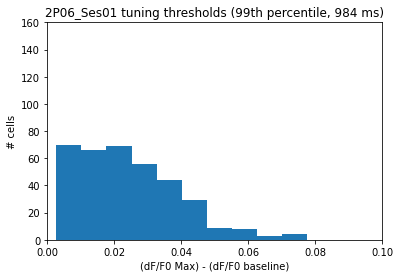

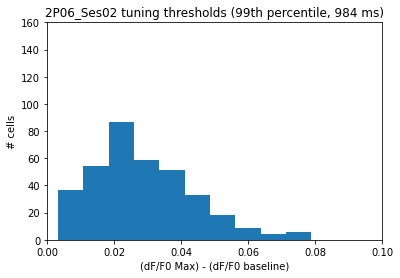

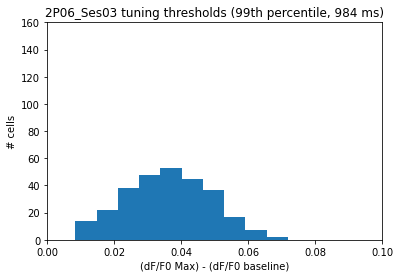

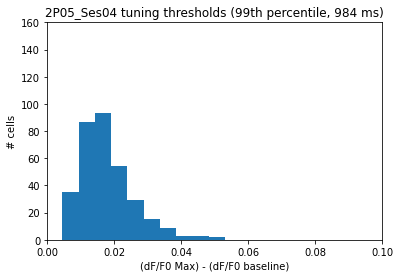

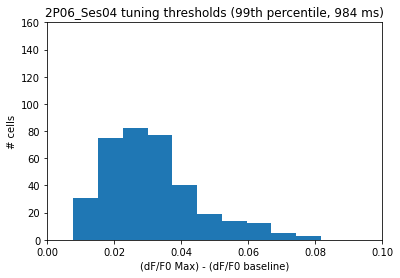

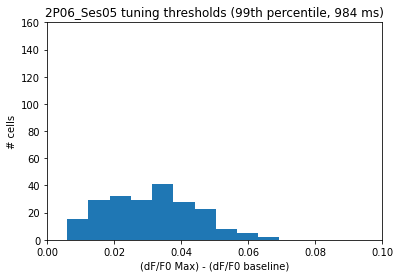

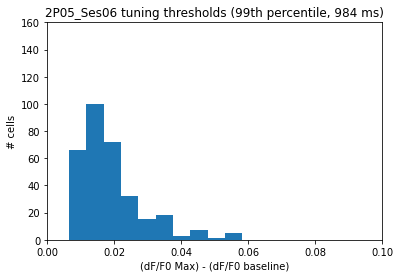

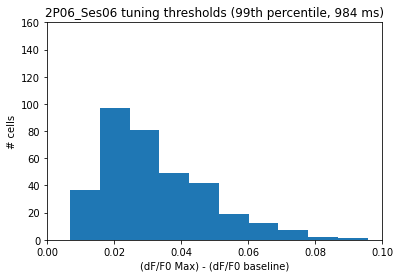

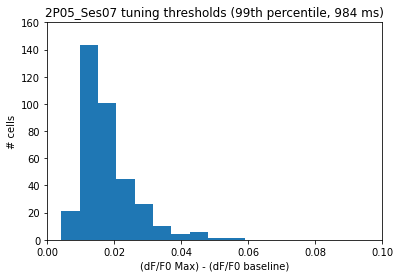

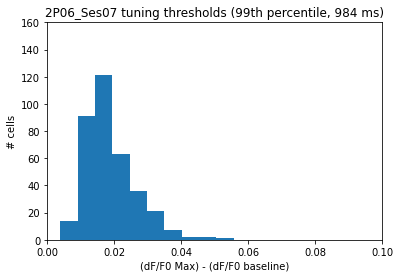

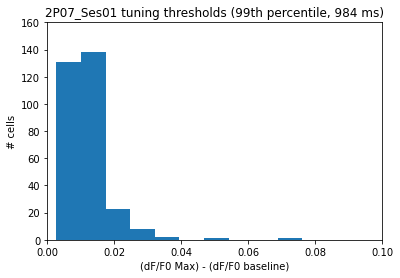

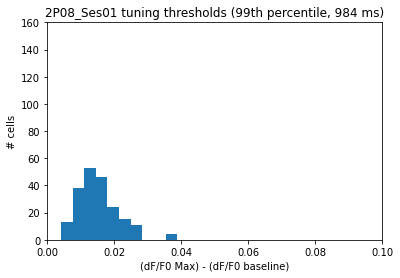

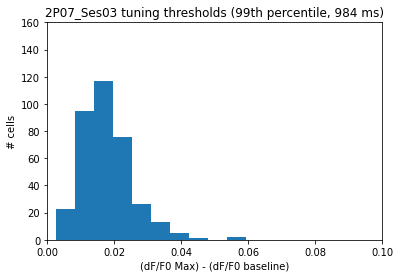

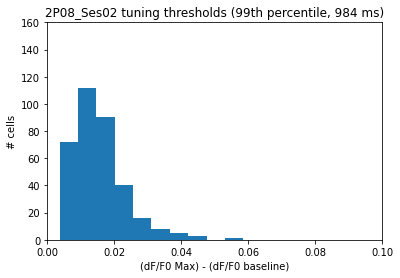

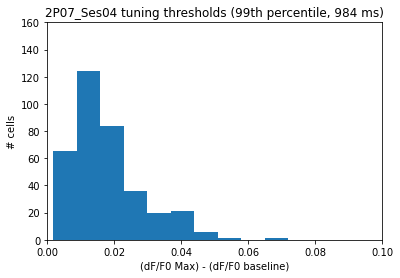

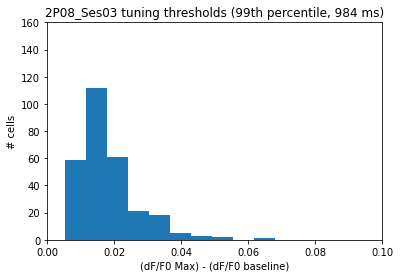

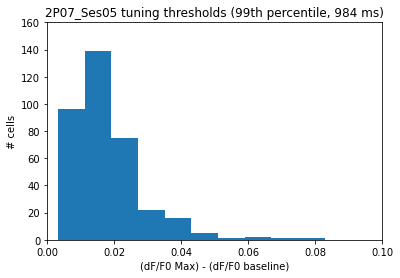

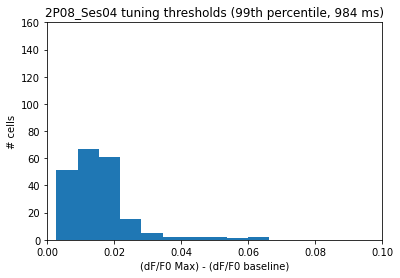

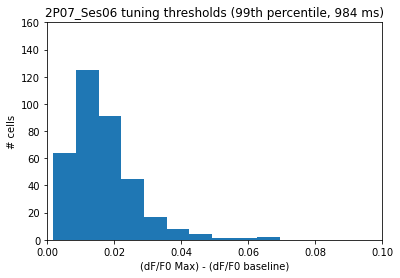

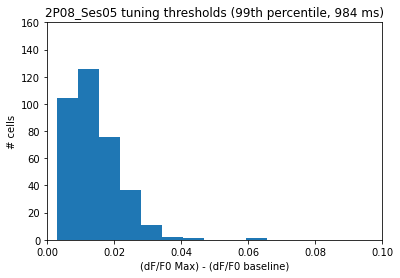

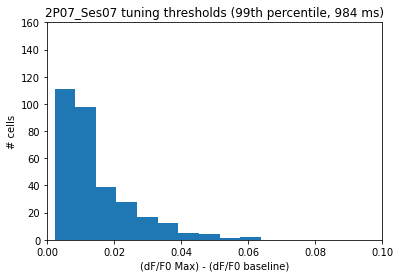

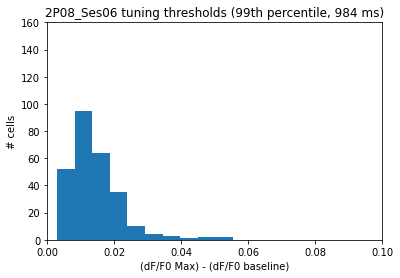

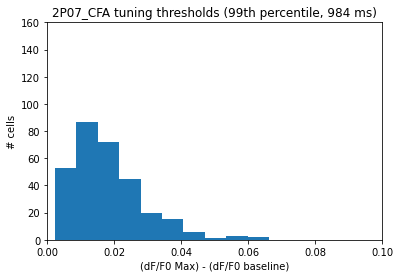

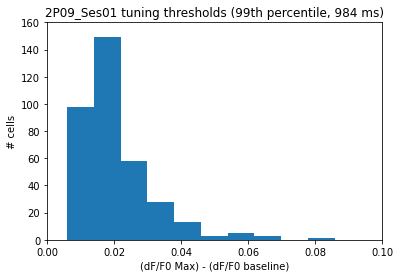

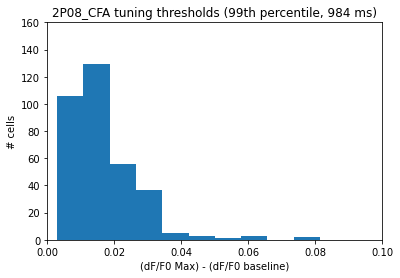

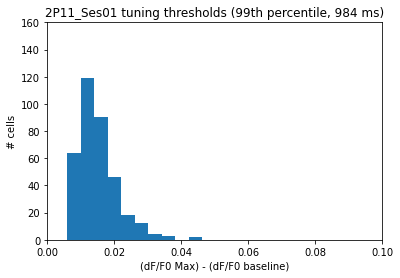

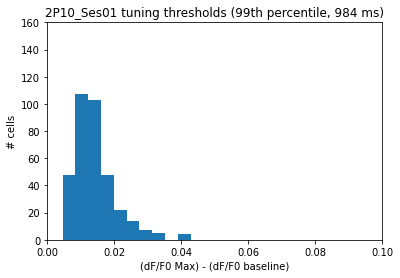

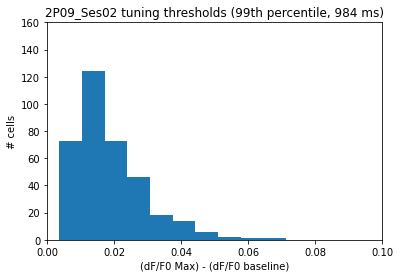

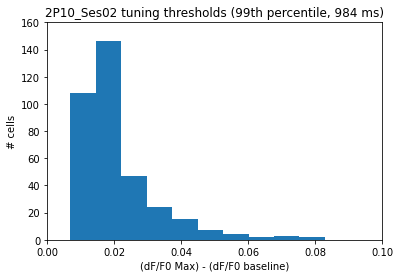

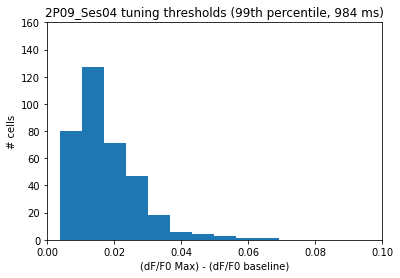

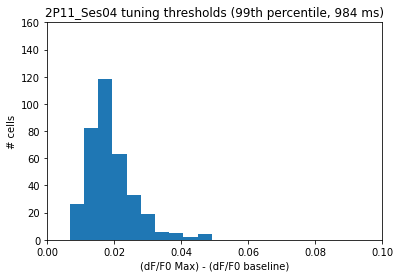

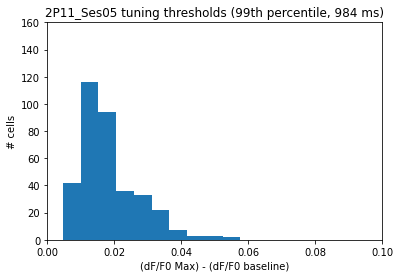

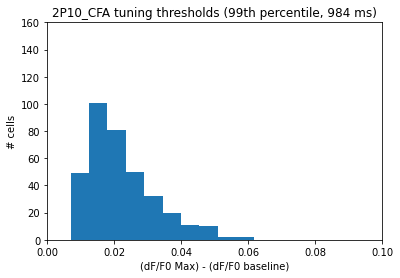

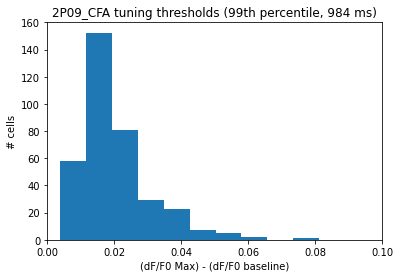

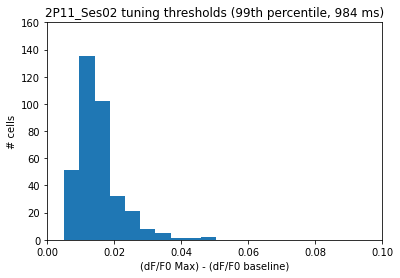

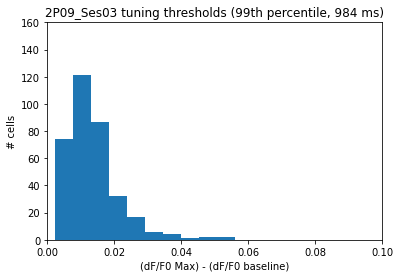

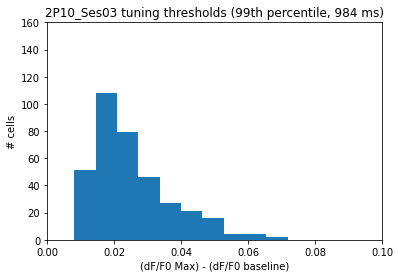

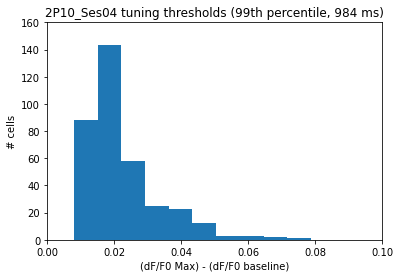

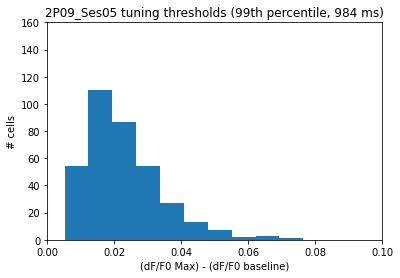

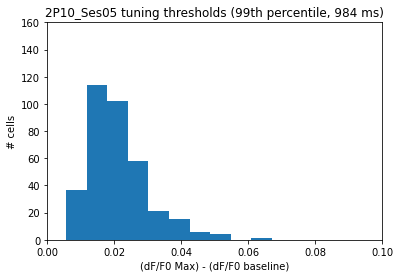

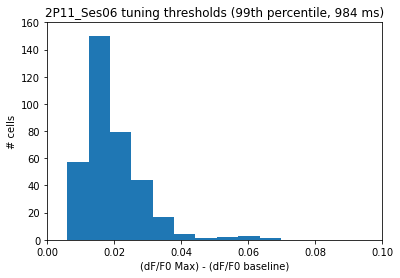

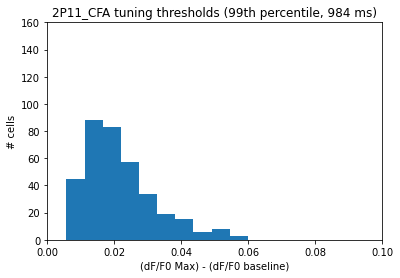

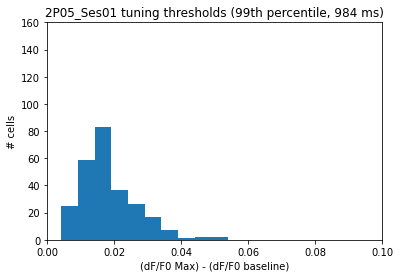

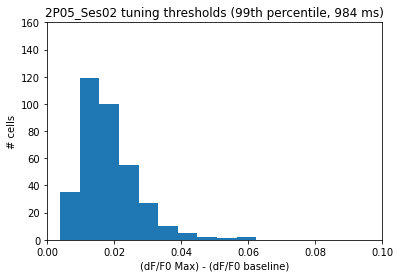

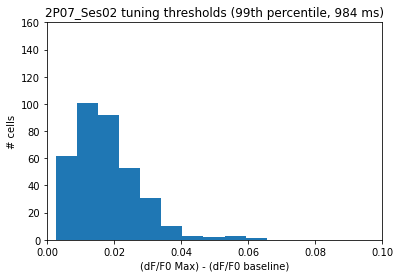

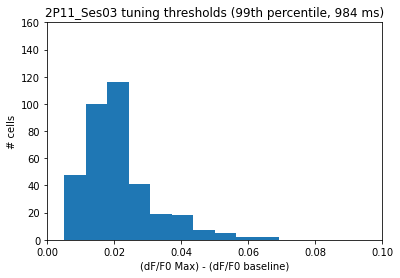

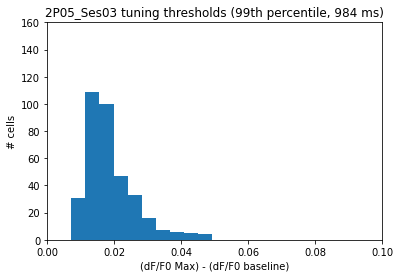

In [13]:
# Plot tuning thresholds distributin for each session
sessions = thresholds99.columns.tolist()
for s in sessions:
    plt.hist(thresholds99[s])
    plt.ylim([0,160])
    plt.ylabel('# cells')
    plt.xlim([0,0.1])
    plt.xlabel ('(dF/F0 Max) - (dF/F0 baseline)')
    plt.title(s+' tuning thresholds (99th percentile, 984 ms)')
    plt.savefig(os.path.join(output_path, 'tuning thresholds_99long_'+s+'.png'))
    plt.show()

/Users/aspra/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6402: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  key,
/Users/aspra/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/aspra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

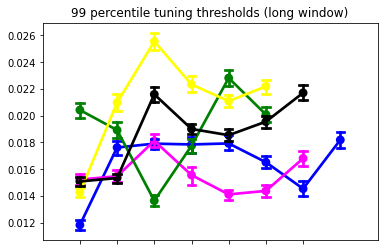

In [7]:
# Plot evolution of tuning threshold across sessions for each mouse
import seaborn as sns

mice = ['2P07','2P08', '2P09', '2P10', '2P11']
colors = ['blue', 'magenta', 'green', 'yellow', 'black']

for m, mouse in enumerate(mice):  
    df = thresholds99.loc[:,thresholds99.columns.str.contains(str(mouse))]
    df.sort_index(axis=1, inplace=True)
    name = mouse+'_CFA'
    cfa = df[name]
    df.drop(name, axis=1, inplace=True)
    df[name]=cfa
    g = sns.pointplot(data=df, ci=68, capsize=.2, color=colors[m])
    g.set(xticklabels=[])
    g.set(xlim=(-1, 8))
    plt.title('99 percentile tuning thresholds (long window)')
    
plt.savefig(os.path.join(output_path, 'tuning thresholds 99.png'))
plt.show()

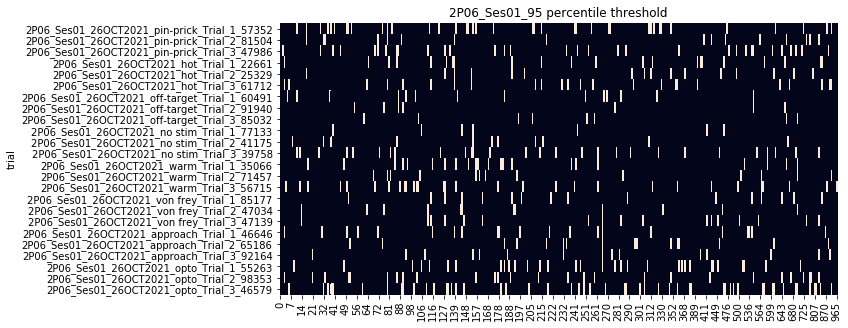

In [81]:
# Rasterplot of tuned neurons for each trial in a given session
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.title(session_name+'_95 percentile threshold')
ax = sns.heatmap(neural_tuning, cbar=False)


plt.savefig(os.path.join(output_path+session_name+'_neural_tuning.png'), bbox_inches='tight')